# Estimate SEIR parameters from data for different countries

In [1]:
%run ./Load-Data.ipynb

In [2]:
from matplotlib import pyplot
%matplotlib inline

pyplot.style.use("fivethirtyeight")# for pretty graphs

# Increase the default plot size and set the color scheme
pyplot.rcParams['figure.figsize'] = 8, 15

In [3]:
%run ./SEIR.ipynb
def predictValues(alpha, beta, gamma, nSteps, N, S_E_I_R_values):
    if(S_E_I_R_values is not None):
        init_vals = S_E_I_R_values
    else:
        init_vals = N-1, 1, 0, 0
    params = alpha, beta, gamma
   
    t = np.arange(nSteps)
#     print('t value is ::: ', t)
    results = population_seir_model(init_vals, params, t, N)
    return results

In [4]:
def computeGamma(infected, removed, axs):    
    dR_dt= np.diff(removed)
    infected[infected == 0] = 0.0001 # to prevent divide by zero
    gamma = dR_dt / infected[1:]
    axs[4].plot(gamma, label='gamma', color='blue')
    axs[4].legend(loc="upper right")
    axs[4].set_title('computeGamma')
    axs[4].tick_params(axis='x', rotation=90)
    axs[4].set_xticks(np.arange(0, (len(gamma)+1), 10.0))
    return gamma.mean()

In [5]:
def computeLoss(yhat, infected, removed):
    offsetOfyHat = 0
    offsetOfinfected = 0
    if(len(infected)>len(yhat[2, :])):
        offsetOfinfected = len(infected)-len(yhat[2, :])
    else:
        offsetOfyHat = len(yhat[2, :])-len(infected)
    loss= infected[offsetOfinfected:] - yhat[2,offsetOfyHat:]
    l1 = (loss*loss).sum()
    
    loss= (removed[offsetOfinfected:] - yhat[3,offsetOfyHat:])
    l2 = (loss*loss).sum()
    
    weightForRecovered = 0.1
    return weightForRecovered * l1 + (1 - weightForRecovered) * l2

In [6]:
def estimateMultiStepSierParams(infected, removed, N, axs, stepSize):
    S_E_I_R_values = N-1, 1, 0, 0
    startIndex=0
    cumulativeAlphaHistory = []
    cumulativeBetaHistory = []
    cumulativeGammaHistory = []
    cumulativeLossHistory = []
    cumulativePredInfected = []
    cumulativePredRemoved = []
    cumulativeParams = []
    
    for index in range(len(infected)):
        if(infected[index]!=0):
            break
    infected = infected[index : ]
    removed = removed[index : ]
    if(stepSize == -1):
        stepSize = len(infected)
    while(startIndex < len(infected)):
        if(startIndex+(stepSize) > len(infected)):
            endIndex = len(infected)
        else:
            endIndex = (startIndex + (stepSize))
        if(endIndex - startIndex < 2):
            break
        infectedDf=infected[startIndex : endIndex]
        removedDf = removed[startIndex : endIndex]
        S_E_I_R_values, params, alphaHistory, betaHistory, gammaHistory, lossHistory, predInfected, predRemoved = estimateSingleStepSierParams(S_E_I_R_values, infectedDf, removedDf, N, axs)
        cumulativeAlphaHistory.extend(alphaHistory)
        cumulativeBetaHistory.extend(betaHistory)
        cumulativeGammaHistory.extend(gammaHistory)
        cumulativeLossHistory.extend(lossHistory)
        cumulativePredInfected.extend(predInfected)
        cumulativePredRemoved.extend(predRemoved)
        cumulativeParams.append(params)
        startIndex = endIndex
    axs[0].plot(cumulativeAlphaHistory, label='alpha',color='blue')
    axs[0].plot(cumulativeBetaHistory, label='beta',color='green')
    axs[0].plot(cumulativeGammaHistory, label='gamma',color='red')
    axs[0].set_title('paramsHistory')  
    axs[0].legend(loc="upper right")
    axs[1].plot(cumulativeLossHistory, label='LossHistory')
    axs[1].set_title('lossHistory')
    axs[1].legend(loc="upper right")
    axs[2].plot(cumulativePredInfected, label = 'Pred-Infected')
    axs[2].set_title('pred-infected & infected')
    axs[2].plot(infected, label = 'Infected')
    axs[2].tick_params(axis='x', rotation=90)
    axs[2].set_xticks(np.arange(0, (len(infected)+1), 10.0))
    axs[2].legend(loc="upper right")
    axs[3].plot(cumulativePredRemoved, label='Pred-Removed')
    axs[3].set_title('pred-removed & removed')
    axs[3].tick_params(axis='x', rotation=90)
    axs[3].plot(removed, label = 'Removed')
    axs[3].legend(loc="upper right")
    axs[3].set_xticks(np.arange(0, (len(removed)+1), 10.0))
    
    
    return cumulativeParams

In [7]:
def estimateSingleStepSierParams(S_E_I_R_values, infected, removed, N, axs):
    minLoss = -1
    minParams=[]
    lossHistory=[]
    alphaHistory=[]
    betaHistory=[]
    gammaHistory=[]
    minYhat = None
   
    alphaSpace = np.arange(0.001,1,0.05)
    betaSpace = np.arange(0.001,1,0.05)
    gammaSpace = np.arange(0,1,0.001)
    
    nSteps = len(infected)
    gamma = computeGamma(infected, removed, axs)
    for alpha in alphaSpace:
        for beta in betaSpace:
#             for gamma in gammaSpace:
            yhat = (predictValues(alpha, beta, gamma, nSteps, N, S_E_I_R_values))
            loss = computeLoss(yhat, infected, removed)
            if(loss < minLoss) or (minLoss == -1):
                minLoss = loss
                minParams = [alpha, beta, gamma]
                minYhat = yhat
            lossHistory.append(loss)
            alphaHistory.append(alpha)
            betaHistory.append(beta)
            gammaHistory.append(gamma)
    S_E_I_R_values = int(minYhat[0, -1]), int(minYhat[1, -1]),int(minYhat[2, -1]),int(minYhat[3, -1])
    return S_E_I_R_values, minParams, alphaHistory, betaHistory, gammaHistory, lossHistory, minYhat[2,1:], minYhat[3,1:]



## Run it for countries

In [8]:
from pandas import *
def computeParamsWithStepSize(stepSize):
    countries = list(["India", "Pakistan", "Italy", "Spain", "France", "Iran", "China", "Germany", "United Kingdom"])
    pyplot.figure(1)
    paramsResultDf = DataFrame({'Country': [], 'Params': []})

    for country in countries:
        fig, axs = pyplot.subplots(1,5)
        fig.set_size_inches(30, 5)
        fig.suptitle(country)
        N = int(populationDf [populationDf['Country']==country]['Population'])
        confirmedTSDf = confirmedDf.loc[confirmedDf["Country/Region"] == country].sum().T[4:]
        recoveredTSDf = recoveredDf.loc[recoveredDf["Country/Region"] == country].sum().T[4:]
        deathsTSDf = deathsDf.loc[deathsDf["Country/Region"] == country].sum().T[4:]
        params = estimateMultiStepSierParams(confirmedTSDf, (recoveredTSDf+deathsTSDf), N, axs, stepSize)
        paramsResultDf = paramsResultDf.append({'Country': country , 'Params': params}, ignore_index=True)

    fig, axs = pyplot.subplots(1,5)
    fig.set_size_inches(18.5, 5)    
    N = int(populationDf [populationDf['Country']=='United States']['Population'])
    params_us = estimateMultiStepSierParams(total_infected_us_timeseries, total_removed_us_timeseries, N, axs, 14)  
    paramsResultDf = paramsResultDf.append({'Country': "US" , 'Params': params_us}, ignore_index=True)
    pandas.set_option('display.max_colwidth', -1)
    display(paramsResultDf)


,Country,Params
0,India,"[[0.051000000000000004, 0.801, 0.022361112929587354]]"
1,Pakistan,"[[0.9510000000000001, 0.401, 0.008707547828204699]]"
2,Italy,"[[0.7010000000000001, 0.35100000000000003, 0.016999671277042074]]"
3,Spain,"[[0.751, 0.35100000000000003, 0.03052855571345924]]"
4,France,"[[0.9510000000000001, 0.251, 0.022251000041520422]]"
5,Iran,"[[0.801, 0.6010000000000001, 0.0559892369205129]]"
6,China,"[[0.7010000000000001, 0.30100000000000005, 0.018241940291190525]]"
7,Germany,"[[0.651, 0.30100000000000005, 0.01925210763852436]]"
8,United Kingdom,"[[0.35100000000000003, 0.35100000000000003, 0.020304587596719412]]"
9,US,"[[0.8510000000000001, 0.35100000000000003, 0.0], [0.051000000000000004, 0.051000000000000004, 0.0], [0.35100000000000003, 0.201, 0.00506608775839545], [0.8510000000000001, 0.501, 0.005340719334982368], [0.8510000000000001, 0.451, 0.0033649543819661504]]"


<Figure size 432x288 with 0 Axes>

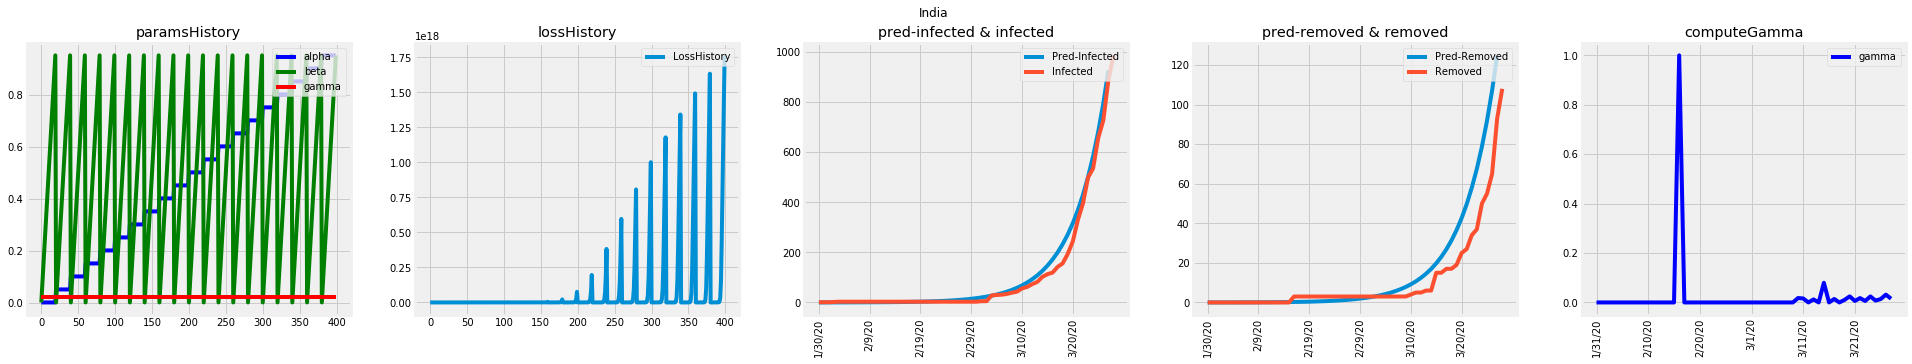

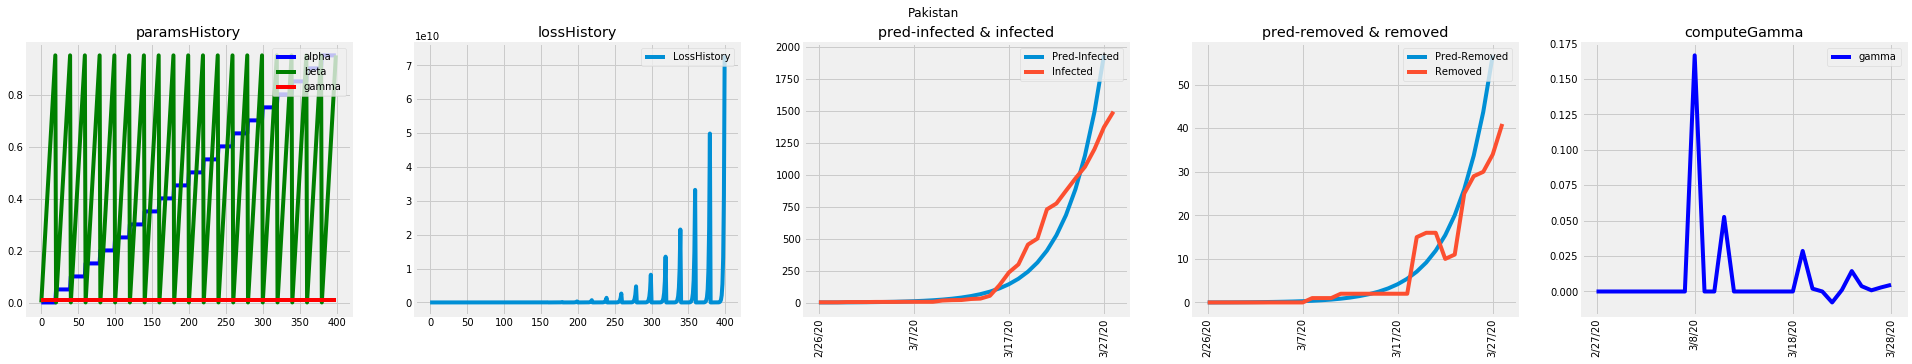

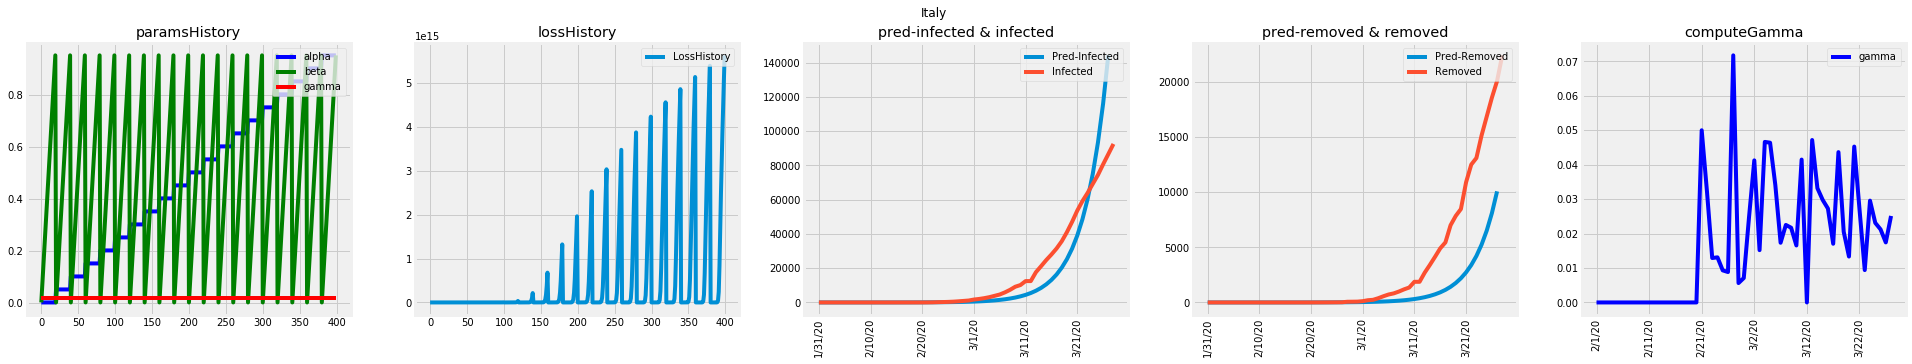

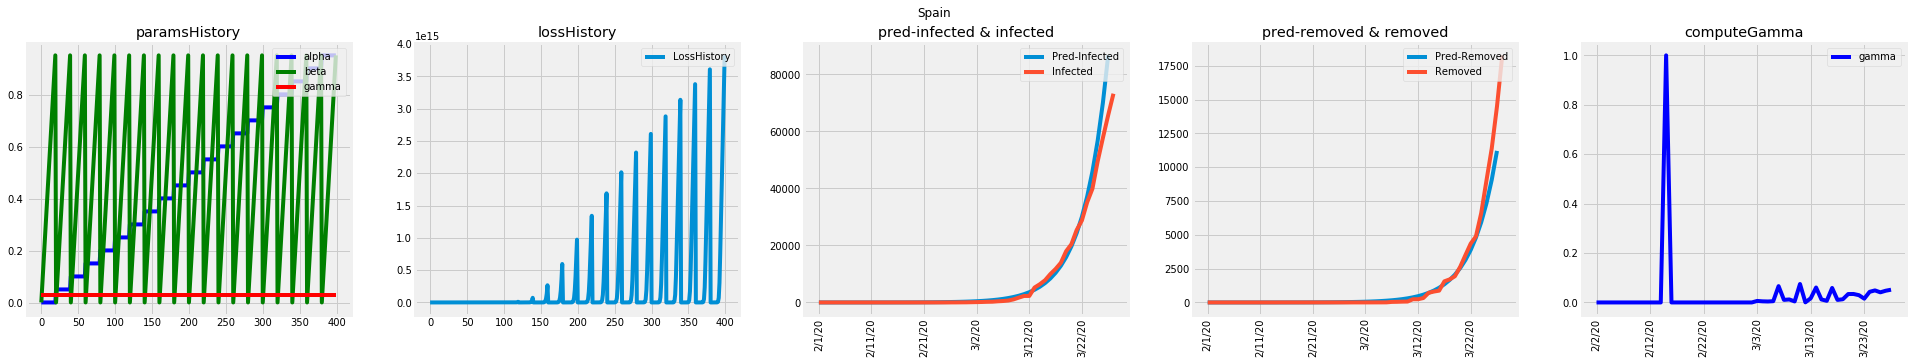

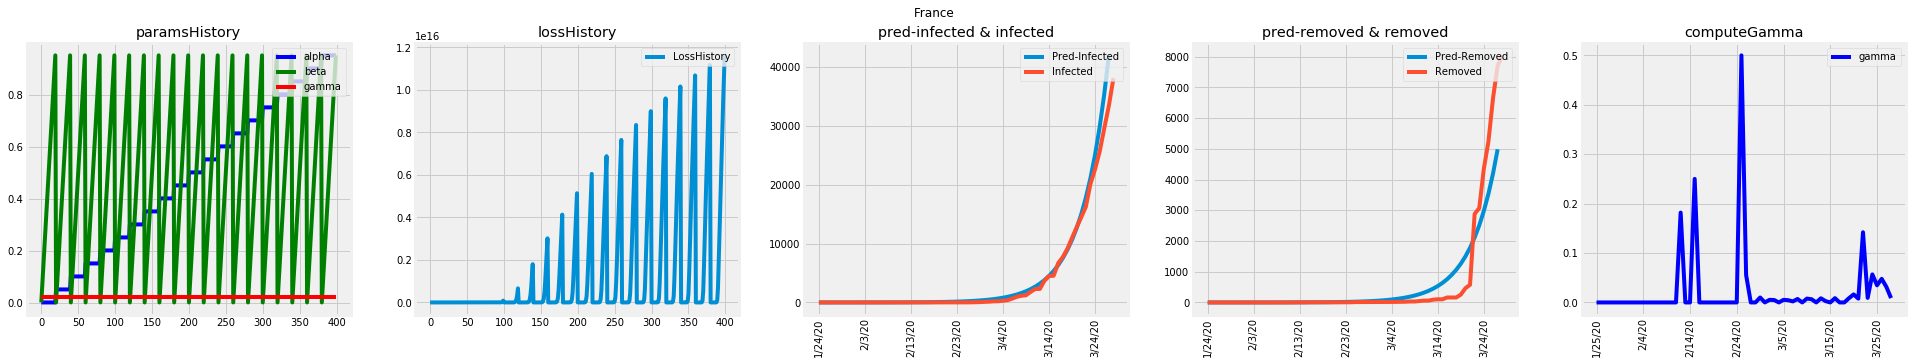

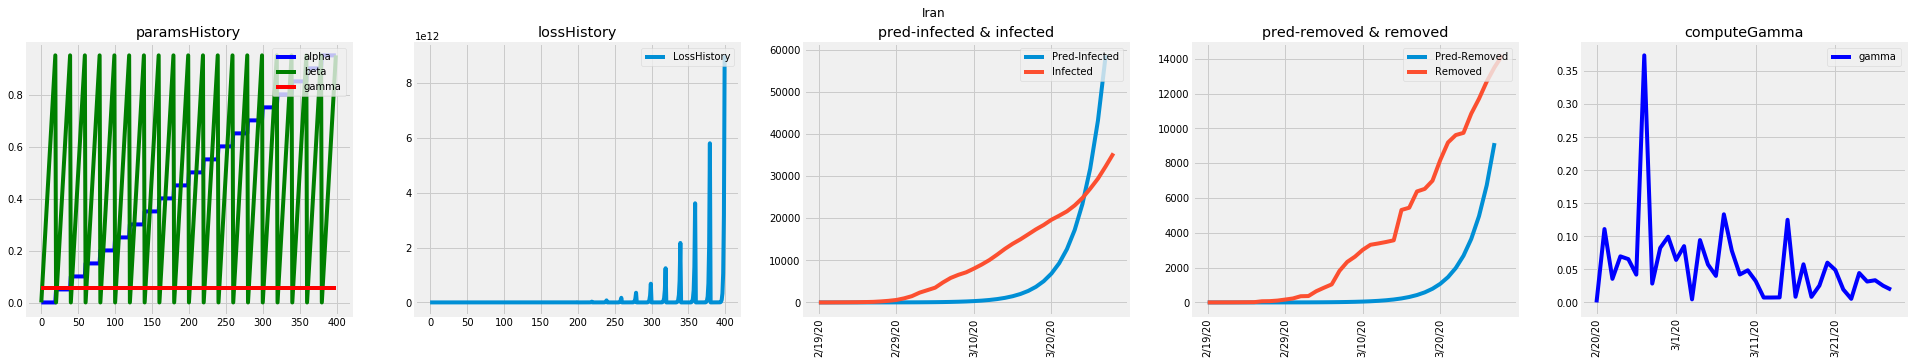

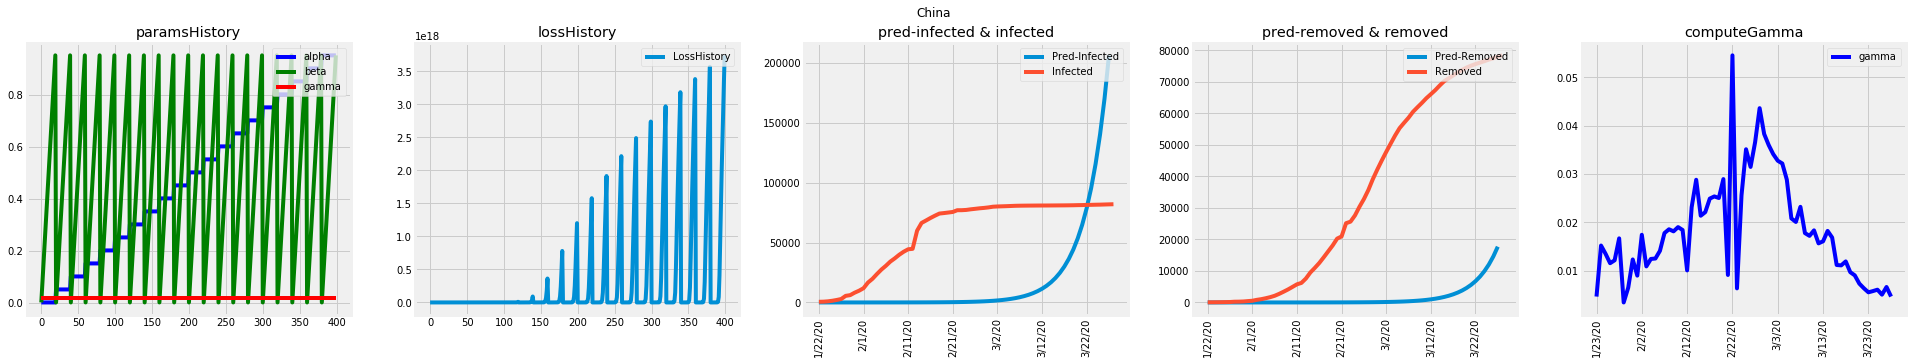

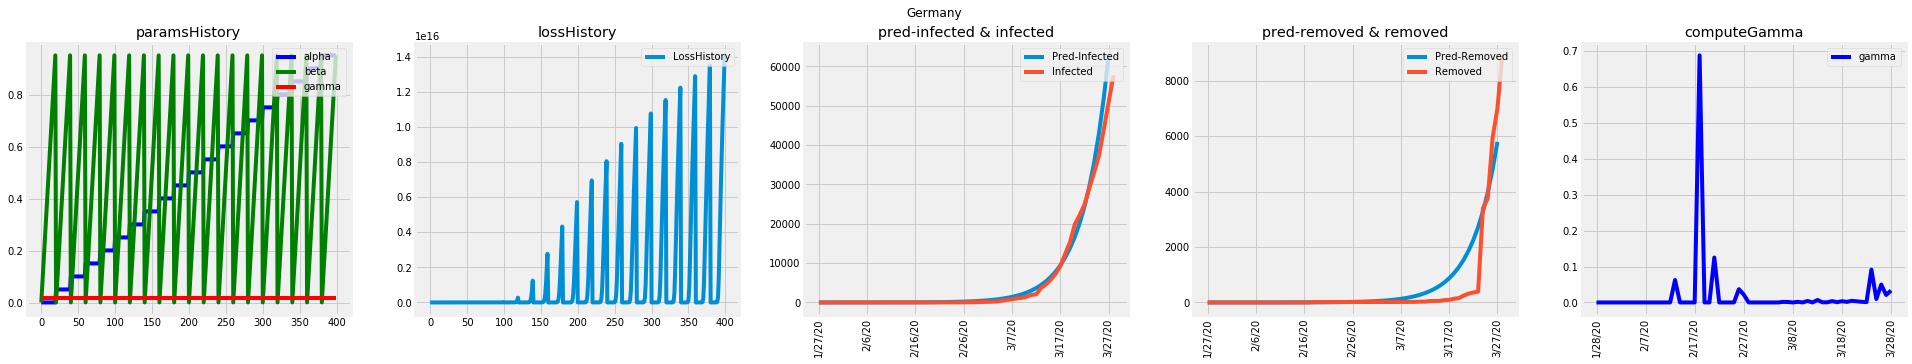

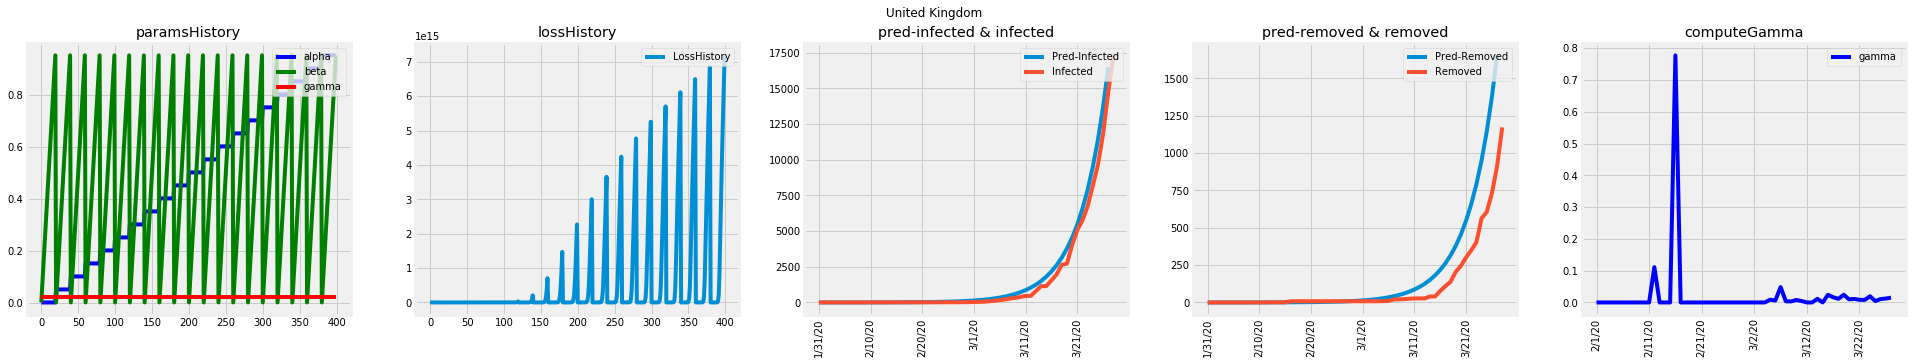

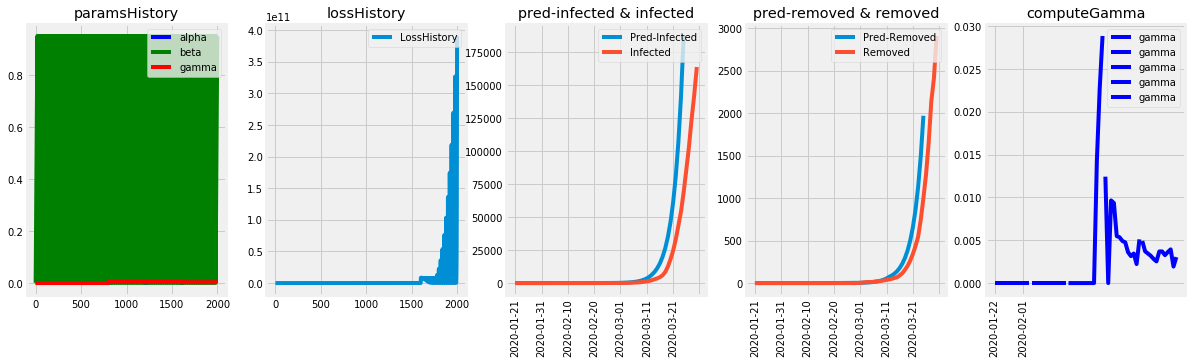

In [9]:
computeParamsWithStepSize(-1)

,Country,Params
0,India,"[[0.9510000000000001, 0.501, 0.0], [0.001, 0.001, 0.0], [0.9510000000000001, 0.15100000000000002, 0.16666666666666666], [0.001, 0.001, 0.0], [0.451, 0.9510000000000001, 0.0], [0.451, 0.201, 0.005664362519201229], [0.9510000000000001, 0.201, 0.01765427444876468], [0.9510000000000001, 0.401, 0.014367273856547208], [0.9510000000000001, 0.201, 0.02338232421707679]]"
1,Pakistan,"[[0.9510000000000001, 0.801, 0.0], [0.101, 0.9510000000000001, 0.027777777777777776], [0.501, 0.9510000000000001, 0.0], [0.9510000000000001, 0.30100000000000005, 0.006407426629758769], [0.501, 0.15100000000000002, 0.0028094140641294167]]"
2,Italy,"[[0.9510000000000001, 0.30100000000000005, 0.0], [0.9510000000000001, 0.101, 0.0], [0.001, 0.001, 0.0], [0.9510000000000001, 0.9510000000000001, 0.024694040742672275], [0.9510000000000001, 0.9510000000000001, 0.03022415487074075], [0.9510000000000001, 0.9510000000000001, 0.019930417950721115], [0.9510000000000001, 0.501, 0.028574731098580487], [0.6010000000000001, 0.101, 0.025945200405337408], [0.9510000000000001, 0.001, 0.02512111774374946]]"
3,Spain,"[[0.9510000000000001, 0.001, 0.0], [0.9510000000000001, 0.201, 0.0], [0.001, 0.001, 0.0], [0.9510000000000001, 0.9510000000000001, 0.0], [0.9510000000000001, 0.9510000000000001, 0.0032376857376857377], [0.901, 0.901, 0.01976082202533325], [0.8510000000000001, 0.35100000000000003, 0.022432596272840652], [0.9510000000000001, 0.30100000000000005, 0.03747699650575089]]"
4,France,"[[0.9510000000000001, 0.801, 0.0], [0.101, 0.001, 0.0], [0.9510000000000001, 0.201, 0.030303030303030304], [0.9510000000000001, 0.001, 0.041666666666666664], [0.251, 0.9510000000000001, 0.0925925925925926], [0.901, 0.551, 0.004233453462215234], [0.9510000000000001, 0.501, 0.0039121996940290745], [0.9510000000000001, 0.35100000000000003, 0.0033346263347477194], [0.9510000000000001, 0.251, 0.049713252323062306], [0.9510000000000001, 0.001, 0.0088439837291694]]"
5,Iran,"[[0.9510000000000001, 0.9510000000000001, 0.054045312055926664], [0.9510000000000001, 0.9510000000000001, 0.06082371959201869], [0.9510000000000001, 0.9510000000000001, 0.06673122579018147], [0.9510000000000001, 0.9510000000000001, 0.035673316928185525], [0.9510000000000001, 0.051000000000000004, 0.03410088060452048], [0.9510000000000001, 0.251, 0.026113457703108498]]"
6,China,"[[0.9510000000000001, 0.9510000000000001, 0.01230469923390729], [0.9510000000000001, 0.9510000000000001, 0.01143997895068429], [0.9510000000000001, 0.9510000000000001, 0.017685136656082744], [0.9510000000000001, 0.9510000000000001, 0.02429530602027793], [0.9510000000000001, 0.35100000000000003, 0.026621380550122697], [0.051000000000000004, 0.001, 0.036891425496781996], [0.15100000000000002, 0.001, 0.021335355167538803], [0.051000000000000004, 0.001, 0.014864826259291563], [0.101, 0.001, 0.007304564633106415], [0.001, 0.001, 0.005458505753156633]]"
7,Germany,"[[0.9510000000000001, 0.9510000000000001, 0.0], [0.9510000000000001, 0.051000000000000004, 0.0], [0.501, 0.101, 0.010416666666666666], [0.9510000000000001, 0.15100000000000002, 0.13541666666666666], [0.501, 0.901, 0.009796027911969941], [0.901, 0.551, 0.0004573502948337163], [0.651, 0.501, 0.001962820555007513], [0.901, 0.35100000000000003, 0.0025240785143229786], [0.9510000000000001, 0.201, 0.04090505560934378]]"
8,United Kingdom,"[[0.9510000000000001, 0.30100000000000005, 0.0], [0.901, 0.6010000000000001, 0.018518518518518517], [0.9510000000000001, 0.001, 0.12962962962962962], [0.9510000000000001, 0.201, 0.0], [0.901, 0.7010000000000001, 0.0014367816091954023], [0.901, 0.35100000000000003, 0.011205700386252506], [0.9510000000000001, 0.501, 0.014533536652377483], [0.9510000000000001, 0.30100000000000005, 0.010332026287523622], [0.9510000000000001, 0.001, 0.015018484288354898]]"
9,US,"[[0.8510000000000001, 0.35100000000000003, 0.0], [0.051000000000000004, 0.051000000000000004, 0.0], [0.35100000000000003, 0.201, 0.00506608775839545], [0.8510000000000001, 0.501, 0.00534071933498236

<Figure size 432x288 with 0 Axes>

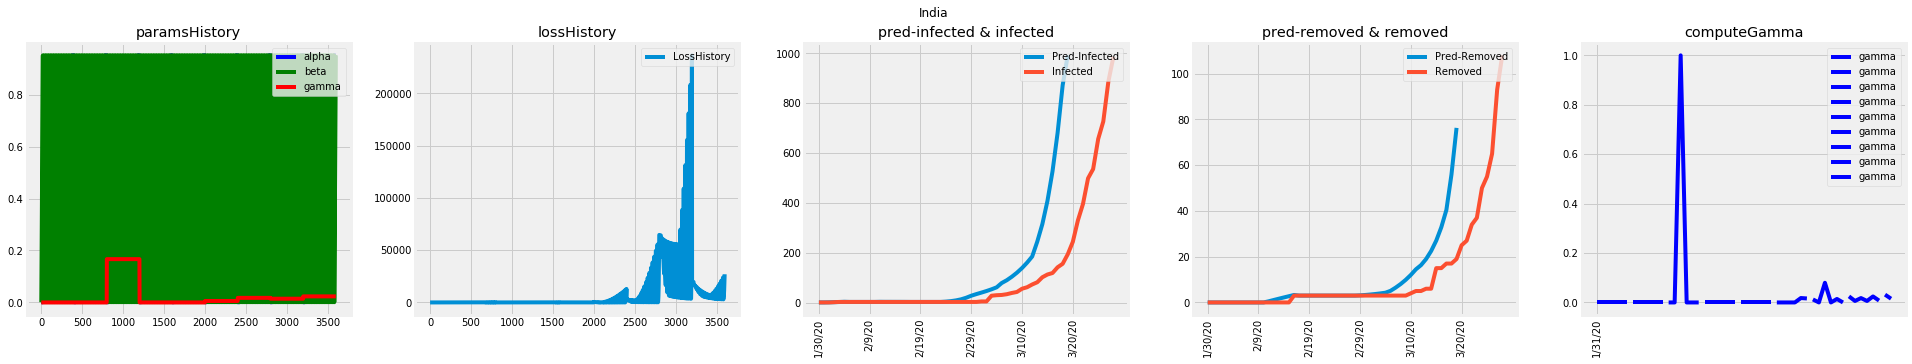

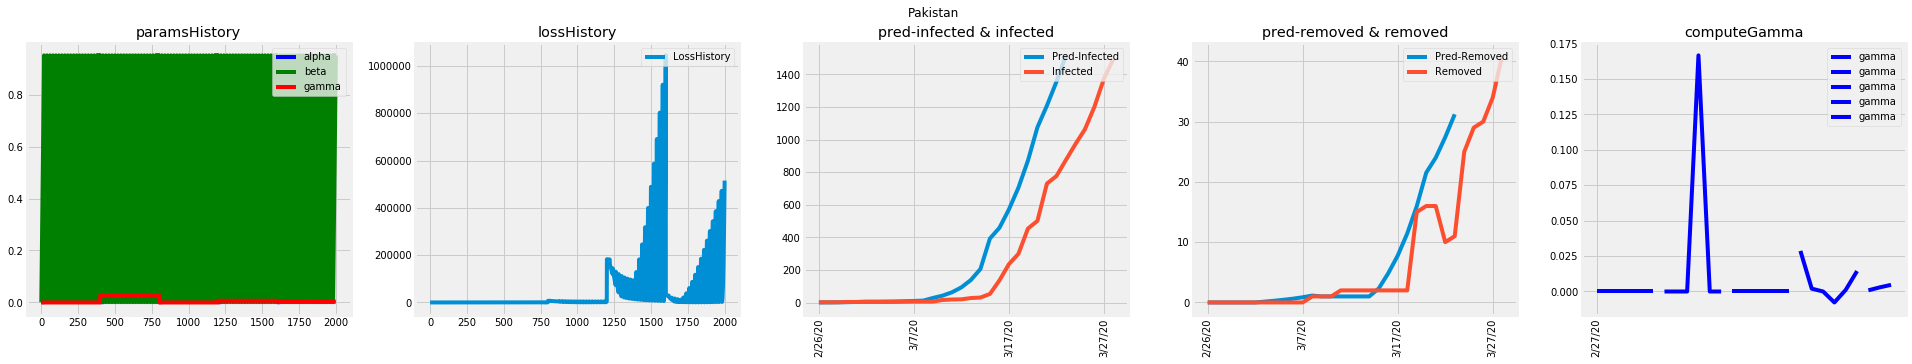

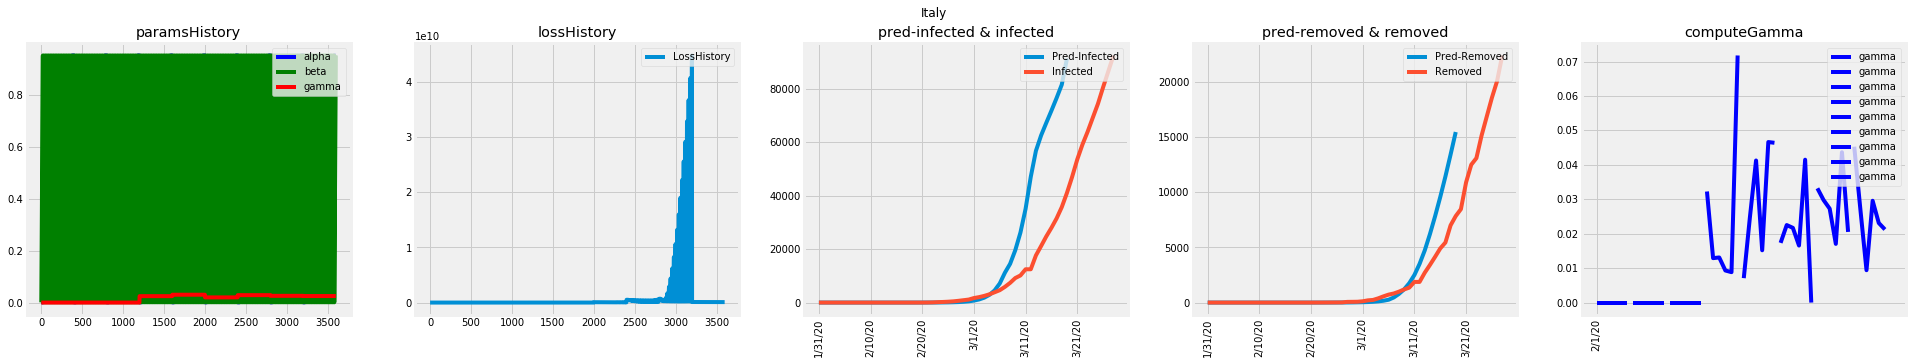

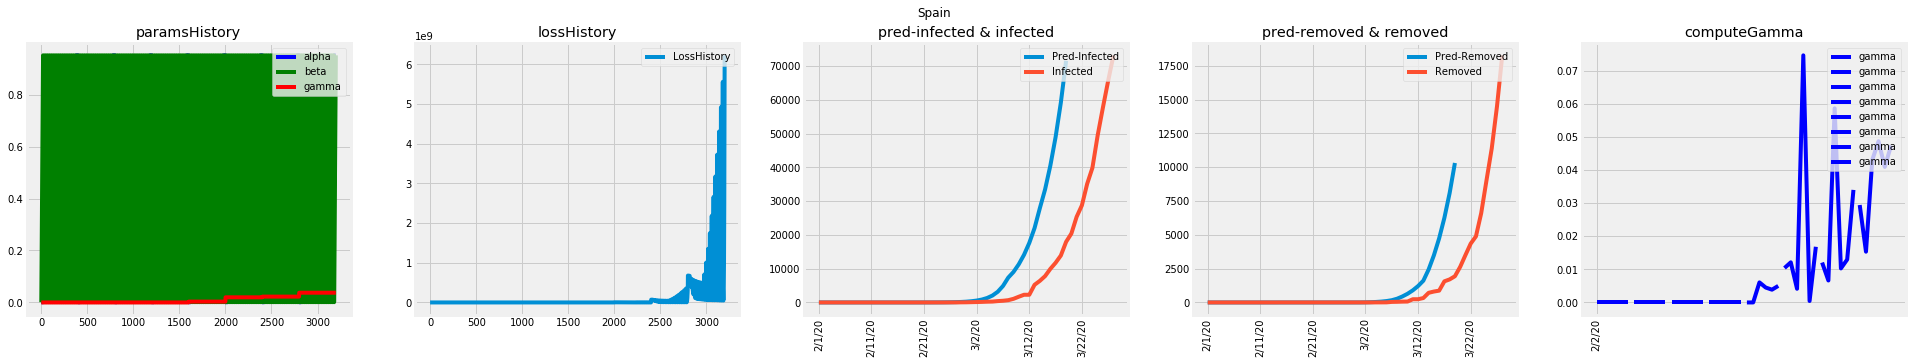

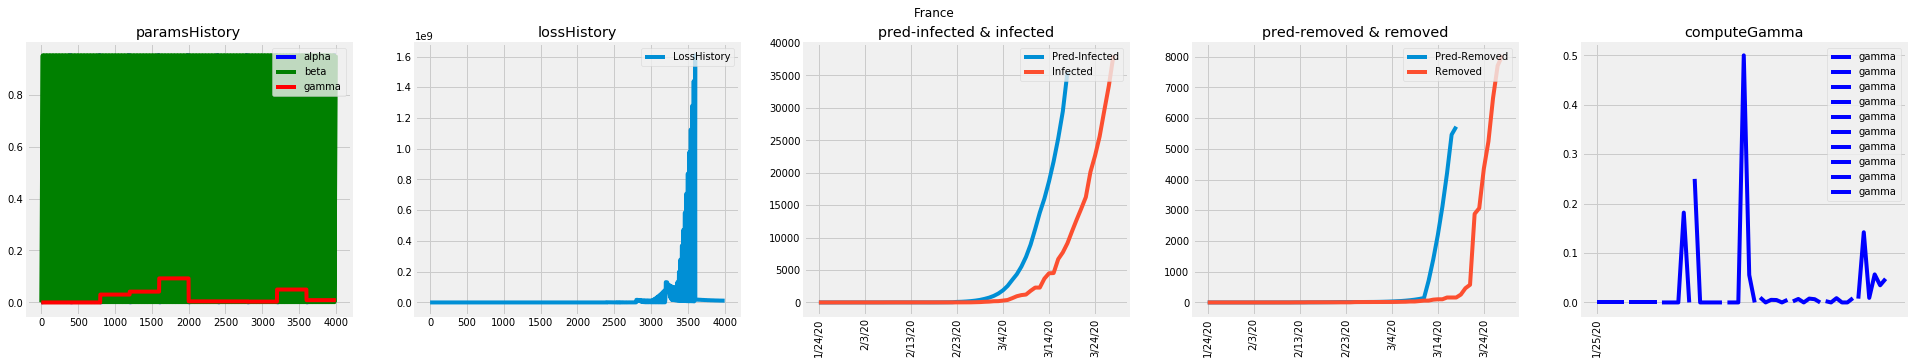

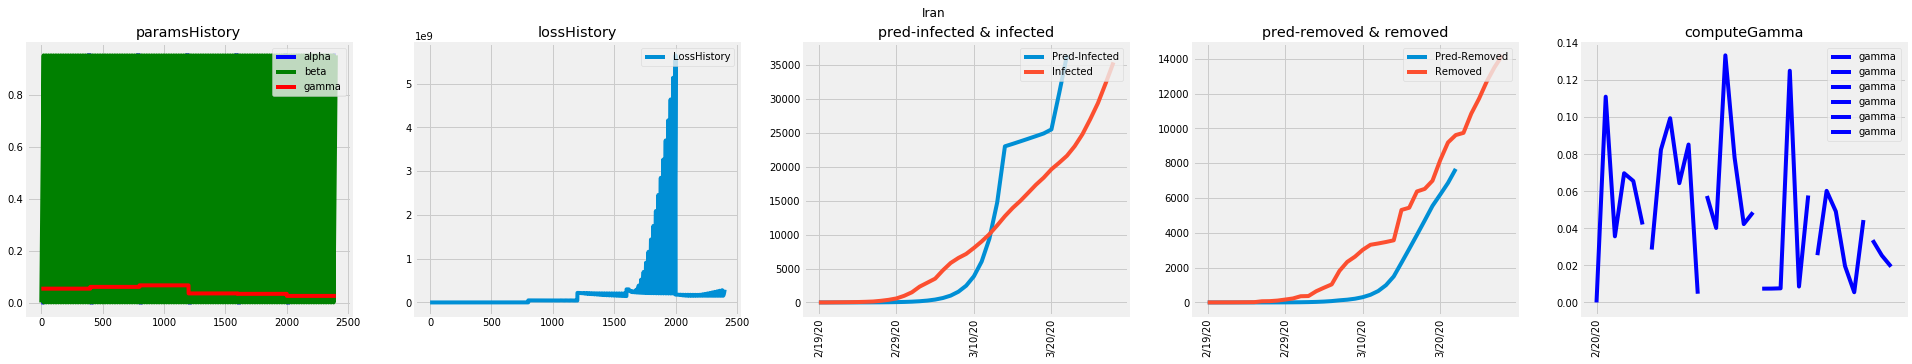

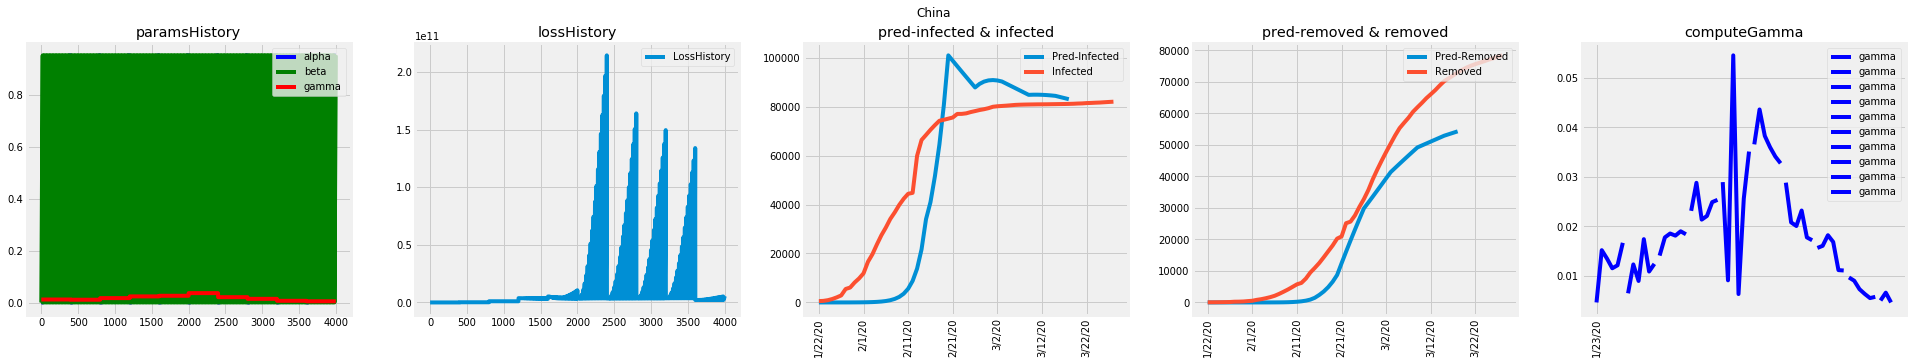

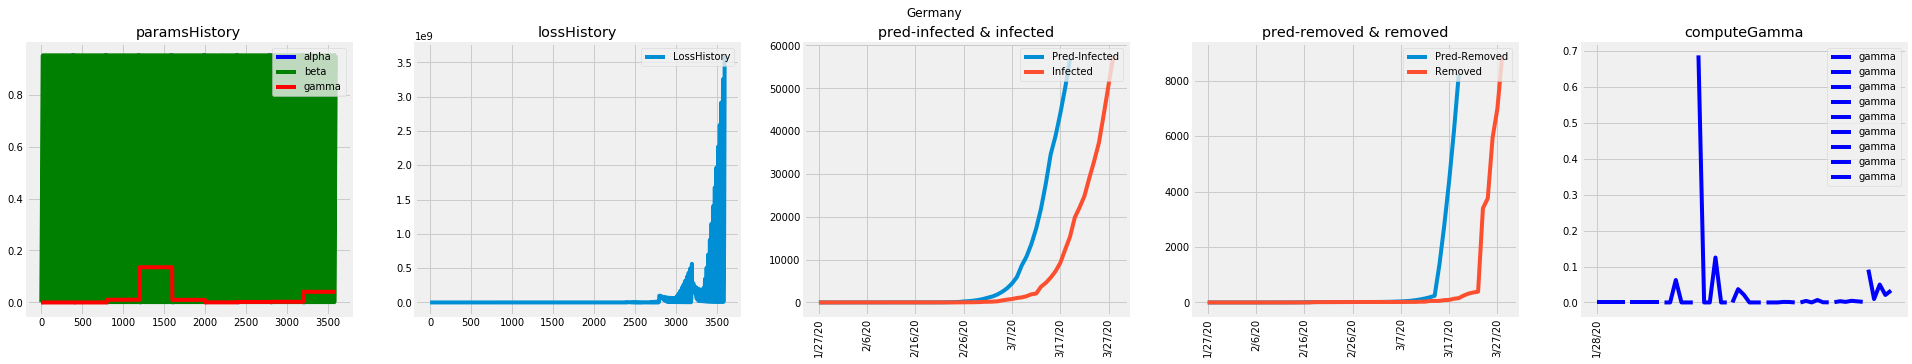

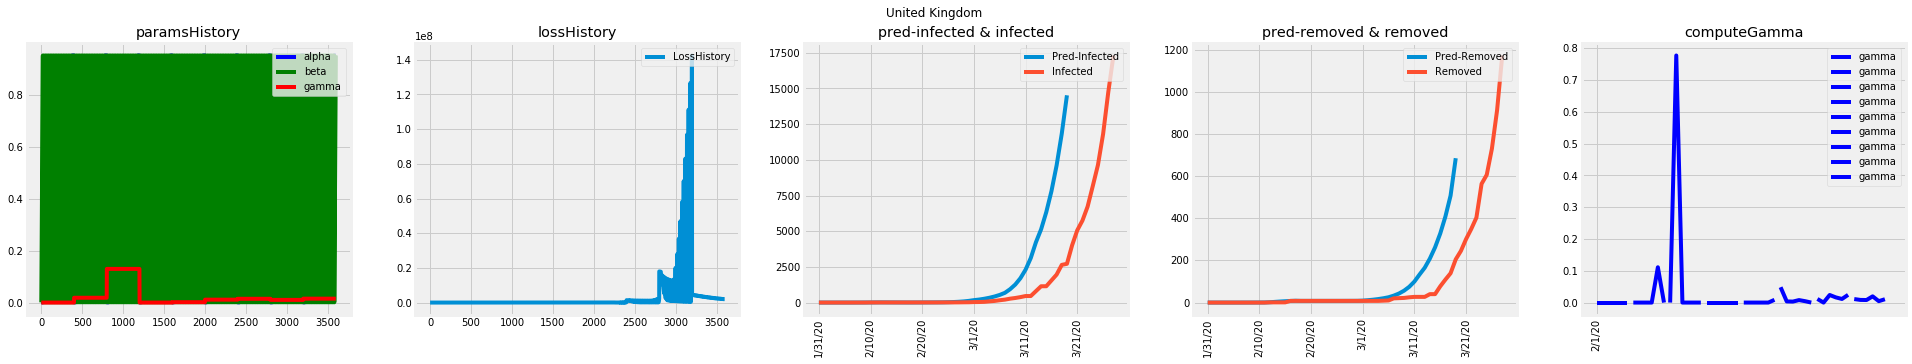

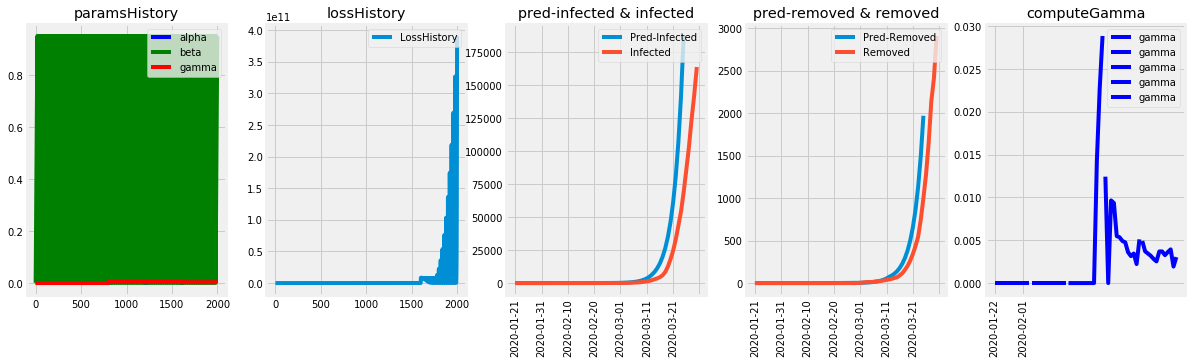

In [10]:
computeParamsWithStepSize(7)

,Country,Params
0,India,"[[0.9510000000000001, 0.15100000000000002, 0.05], [0.051000000000000004, 0.8510000000000001, 0.0016993087557603686], [0.101, 0.451, 0.016434898425053718]]"
1,Pakistan,"[[0.30100000000000005, 0.901, 0.010964912280701754], [0.9510000000000001, 0.201, 0.0050635737060310574]]"
2,Italy,"[[0.751, 0.101, 0.0], [0.9510000000000001, 0.901, 0.024440170820789028], [0.651, 0.15100000000000002, 0.0255339402302507]]"
3,Spain,"[[0.7010000000000001, 0.15100000000000002, 0.05], [0.551, 0.901, 0.010199552328905698], [0.7010000000000001, 0.30100000000000005, 0.03180075996315671]]"
4,France,"[[0.9510000000000001, 0.201, 0.00909090909090909], [0.101, 0.651, 0.04154781381644235], [0.901, 0.30100000000000005, 0.018320360416187814], [0.35100000000000003, 0.001, 0.0088439837291694]]"
5,Iran,"[[0.9510000000000001, 0.9510000000000001, 0.07790790581046396], [0.9510000000000001, 0.251, 0.031594091378639846]]"
6,China,"[[0.9510000000000001, 0.9510000000000001, 0.013228265377502643], [0.9510000000000001, 0.251, 0.02916836980737548], [0.001, 0.001, 0.01456576475463616], [0.001, 0.001, 0.005458505753156633]]"
7,Germany,"[[0.801, 0.251, 0.003125], [0.101, 0.8510000000000001, 0.0437010134620411], [0.9510000000000001, 0.251, 0.012429348233529224]]"
8,United Kingdom,"[[0.9510000000000001, 0.251, 0.04444444444444444], [0.101, 0.7010000000000001, 0.004097622647414861], [0.551, 0.30100000000000005, 0.012434676745054706]]"
9,US,"[[0.8510000000000001, 0.35100000000000003, 0.0], [0.051000000000000004, 0.051000000000000004, 0.0], [0.35100000000000003, 0.201, 0.00506608775839545], [0.8510000000000001, 0.501, 0.005340719334982368], [0.8510000000000001, 0.451, 0.0033649543819661504]]"


<Figure size 432x288 with 0 Axes>

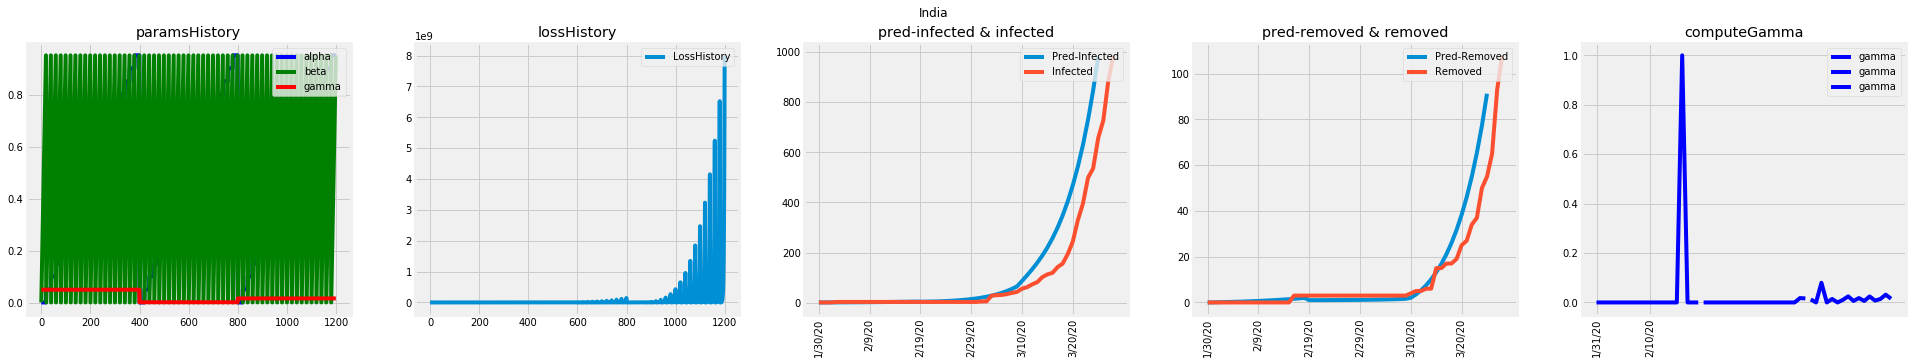

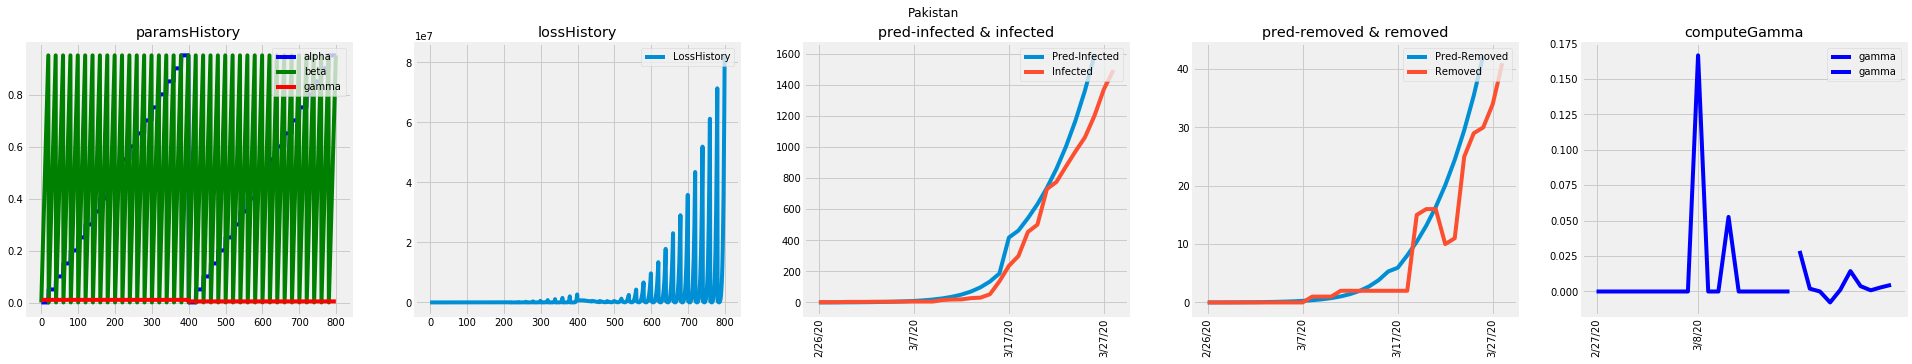

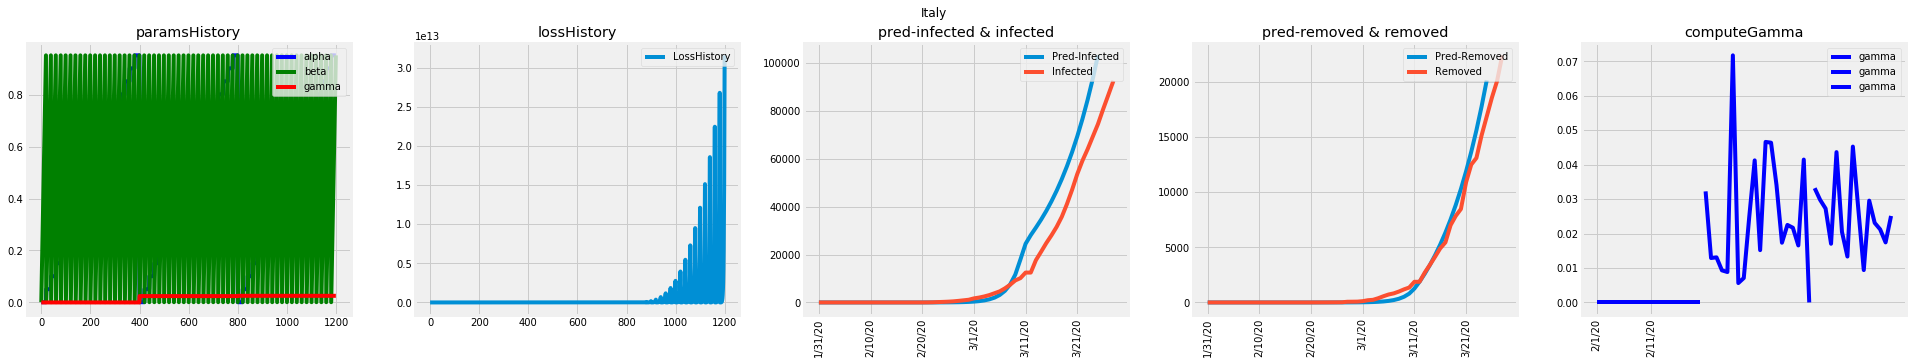

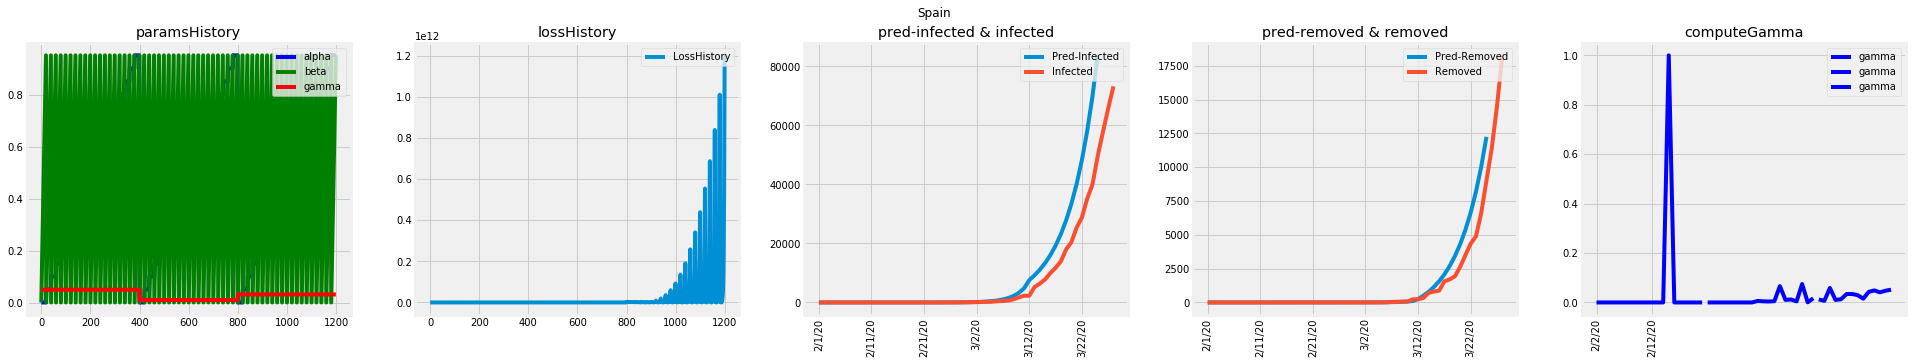

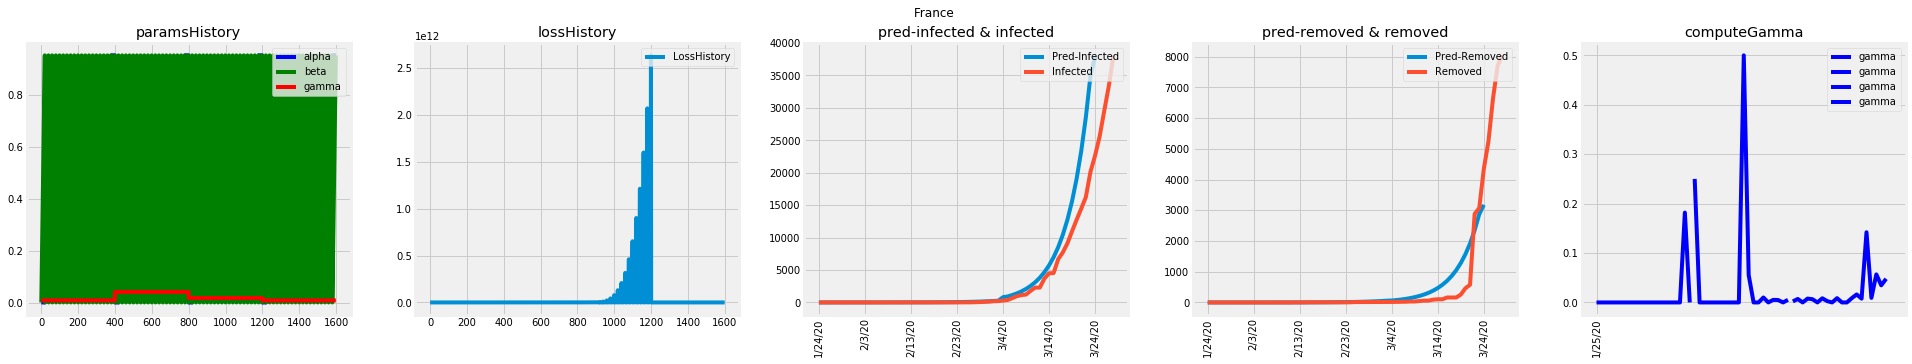

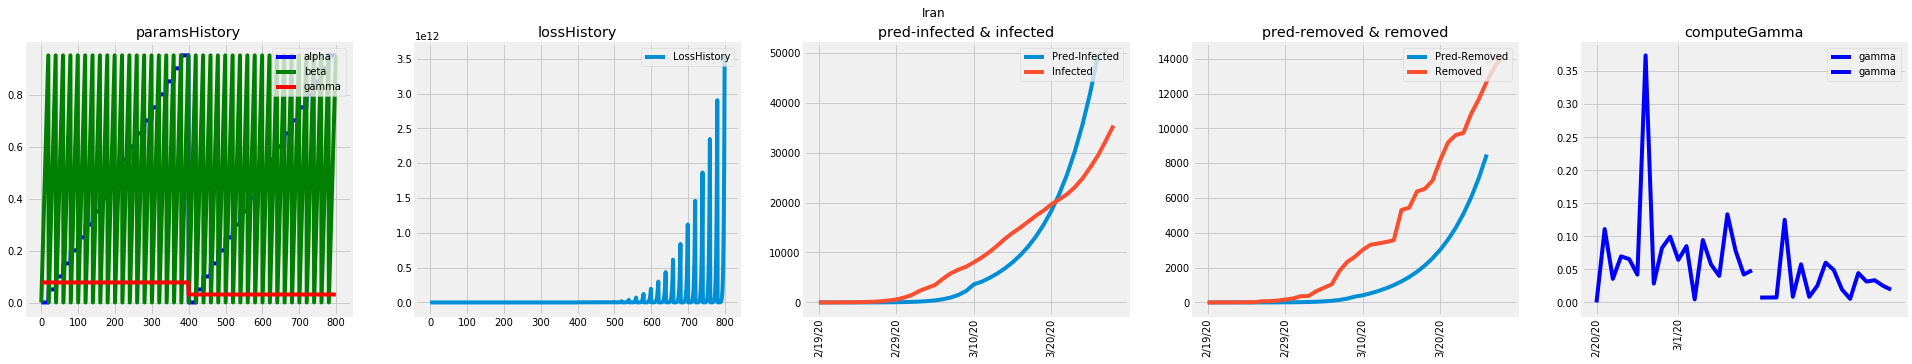

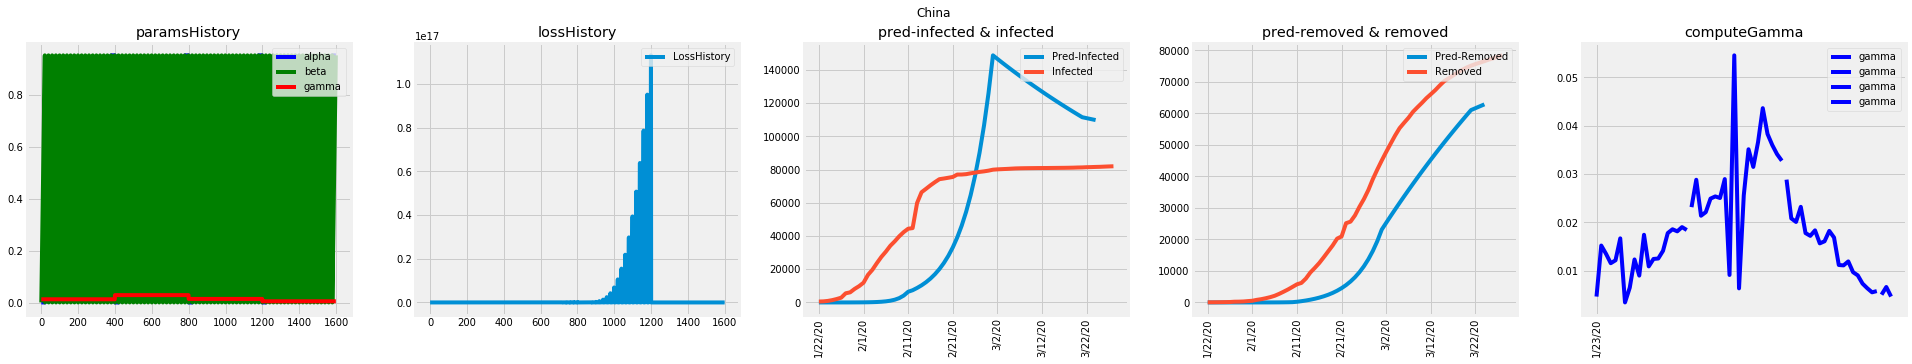

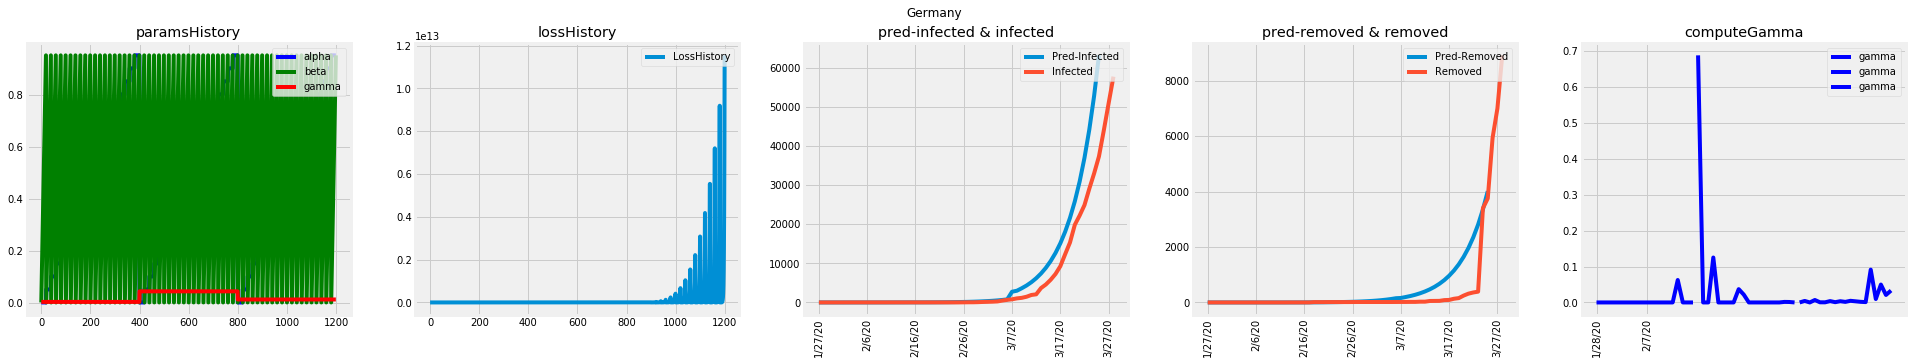

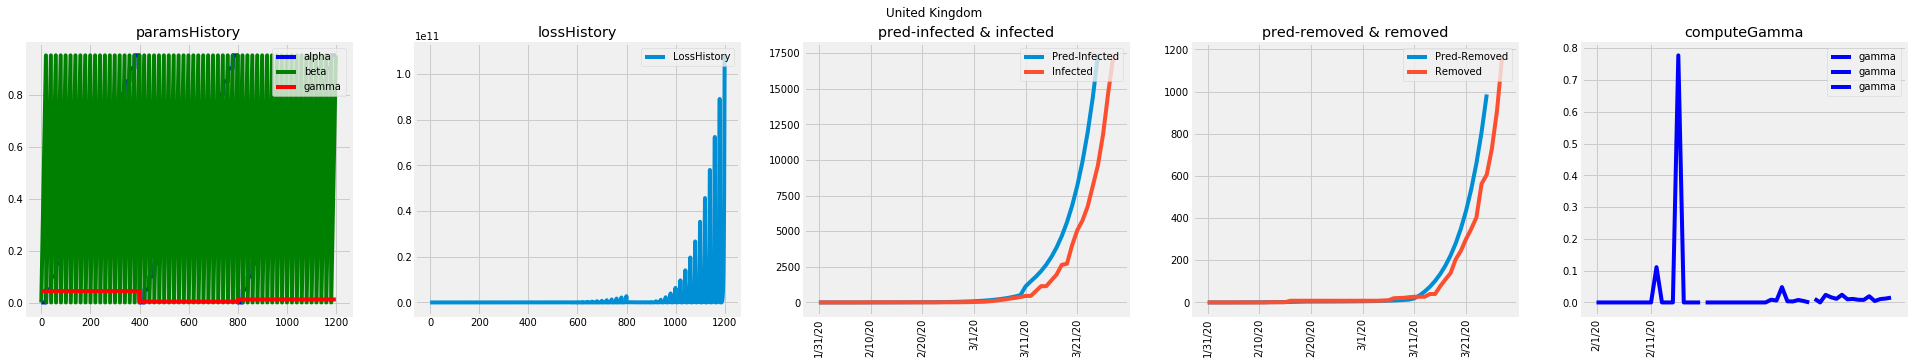

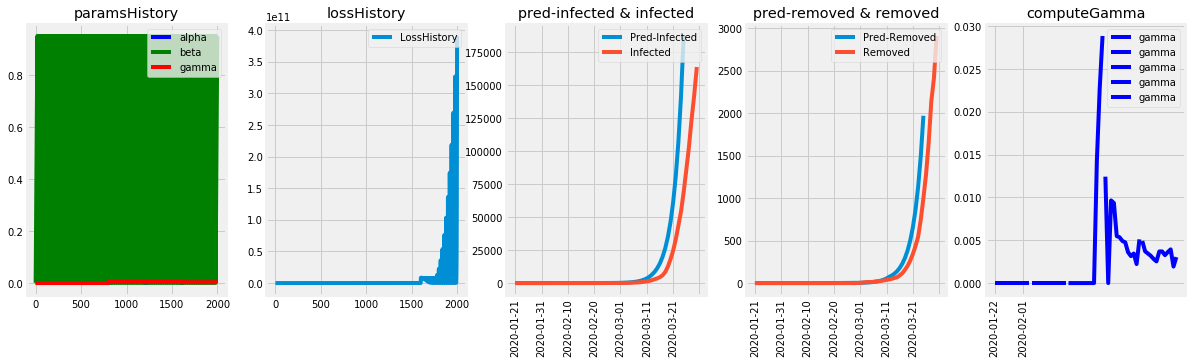

In [11]:
computeParamsWithStepSize(21)

,Country,Params
0,India,"[[0.9510000000000001, 0.15100000000000002, 0.0], [0.9510000000000001, 0.101, 0.07692307692307693], [0.901, 0.401, 0.0026143211627082594], [0.451, 0.30100000000000005, 0.015572197552491293], [0.801, 0.101, 0.02338232421707679]]"
1,Pakistan,"[[0.9510000000000001, 0.35100000000000003, 0.01282051282051282], [0.901, 0.651, 0.002957273829119432], [0.051000000000000004, 0.9510000000000001, 0.0028094140641294167]]"
2,Italy,"[[0.9510000000000001, 0.15100000000000002, 0.0], [0.8510000000000001, 0.9510000000000001, 0.015243403419694896], [0.901, 0.35100000000000003, 0.025769887794547405], [0.8510000000000001, 0.201, 0.026188773584755656], [0.001, 0.001, 0.02512111774374946]]"
3,Spain,"[[0.651, 0.101, 0.0], [0.101, 0.901, 0.0], [0.7010000000000001, 0.751, 0.015691618967547227], [0.901, 0.30100000000000005, 0.03028501628858096]]"
4,France,"[[0.9510000000000001, 0.251, 0.0], [0.9510000000000001, 0.101, 0.033216783216783216], [0.201, 0.9510000000000001, 0.04468894433298823], [0.9510000000000001, 0.30100000000000005, 0.003992506210092664], [0.9510000000000001, 0.251, 0.04232358492414855]]"
5,Iran,"[[0.9510000000000001, 0.9510000000000001, 0.08179345456247175], [0.9510000000000001, 0.8510000000000001, 0.04975081458796426], [0.15100000000000002, 0.051000000000000004, 0.031459239767733745]]"
6,China,"[[0.9510000000000001, 0.9510000000000001, 0.011224464958836028], [0.9510000000000001, 0.9510000000000001, 0.020150680142553827], [0.9510000000000001, 0.001, 0.03173448615744216], [0.9510000000000001, 0.051000000000000004, 0.018119409231456742], [0.001, 0.001, 0.006628904164717783]]"
7,Germany,"[[0.9510000000000001, 0.401, 0.0], [0.051000000000000004, 0.15100000000000002, 0.0673076923076923], [0.35100000000000003, 0.751, 0.004732328403140149], [0.9510000000000001, 0.30100000000000005, 0.0023564819771624353], [0.9510000000000001, 0.251, 0.04090505560934378]]"
8,United Kingdom,"[[0.9510000000000001, 0.30100000000000005, 0.008547008547008546], [0.9510000000000001, 0.051000000000000004, 0.05982905982905983], [0.8510000000000001, 0.6010000000000001, 0.006304034842176709], [0.801, 0.35100000000000003, 0.012242961516319385], [0.9510000000000001, 0.001, 0.015018484288354898]]"
9,US,"[[0.8510000000000001, 0.35100000000000003, 0.0], [0.051000000000000004, 0.051000000000000004, 0.0], [0.35100000000000003, 0.201, 0.00506608775839545], [0.8510000000000001, 0.501, 0.005340719334982368], [0.8510000000000001, 0.451, 0.0033649543819661504]]"


<Figure size 432x288 with 0 Axes>

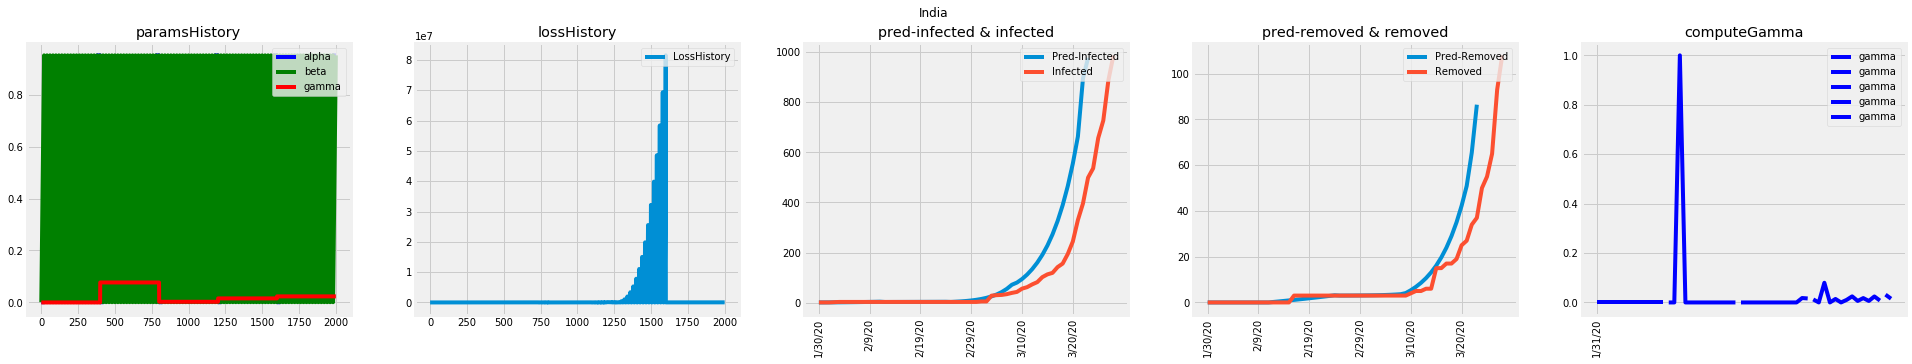

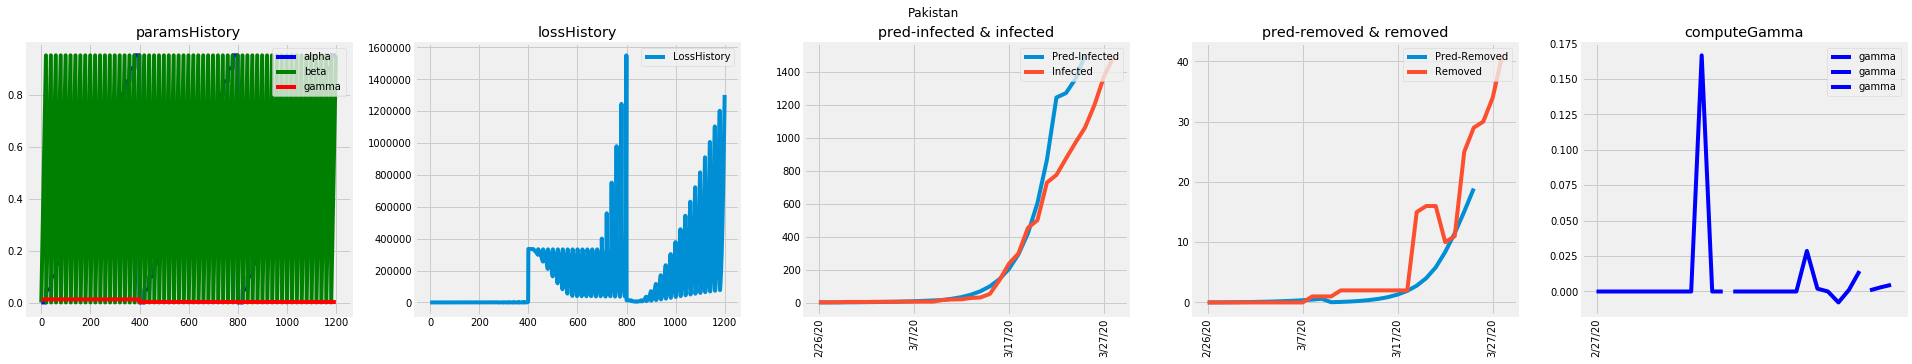

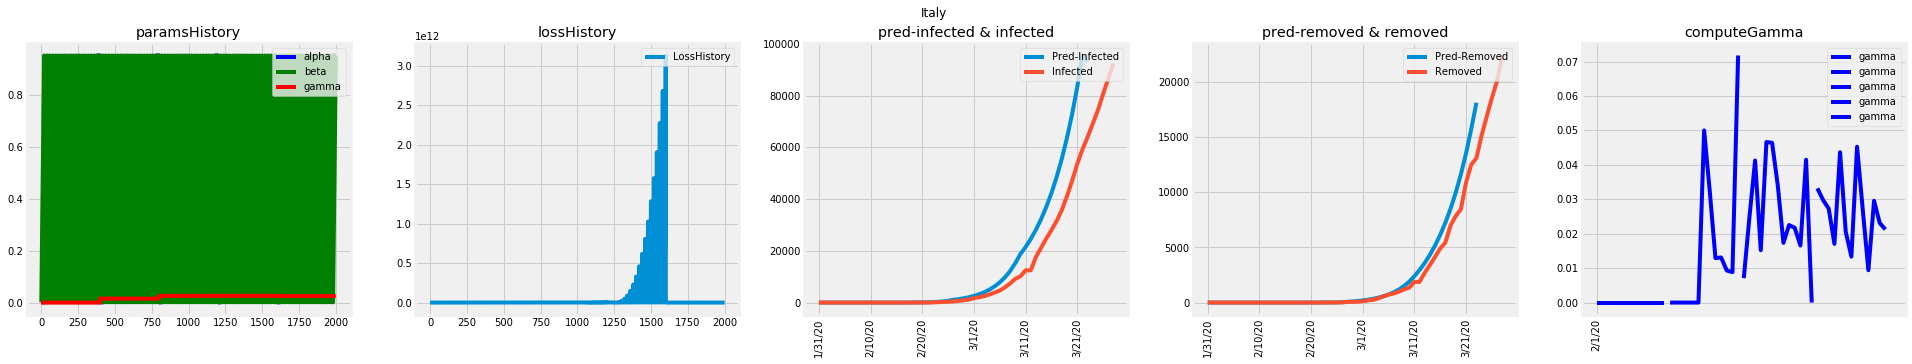

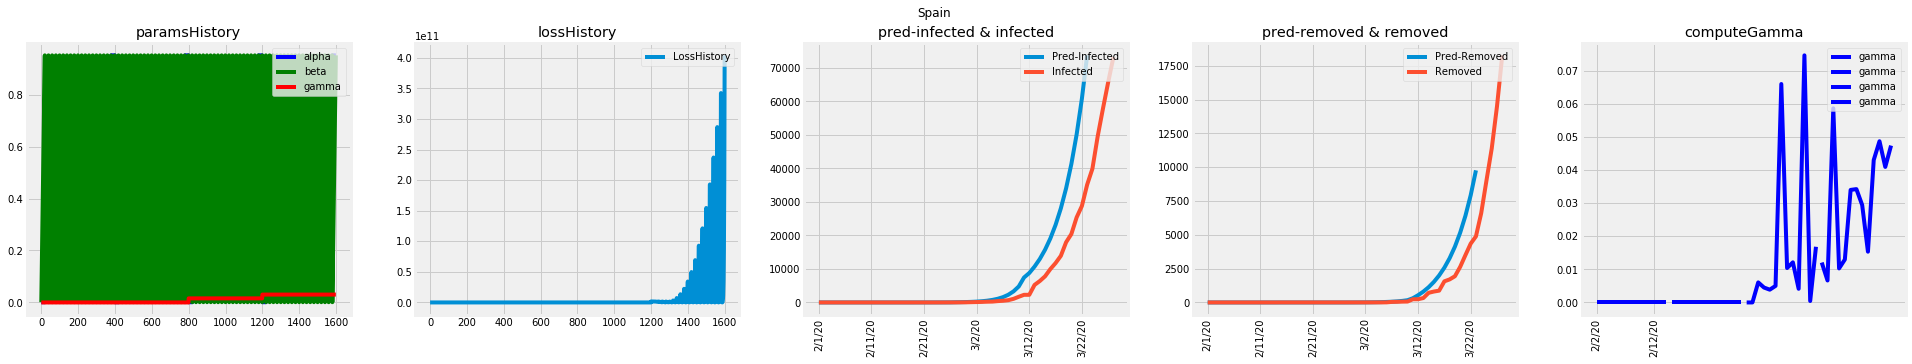

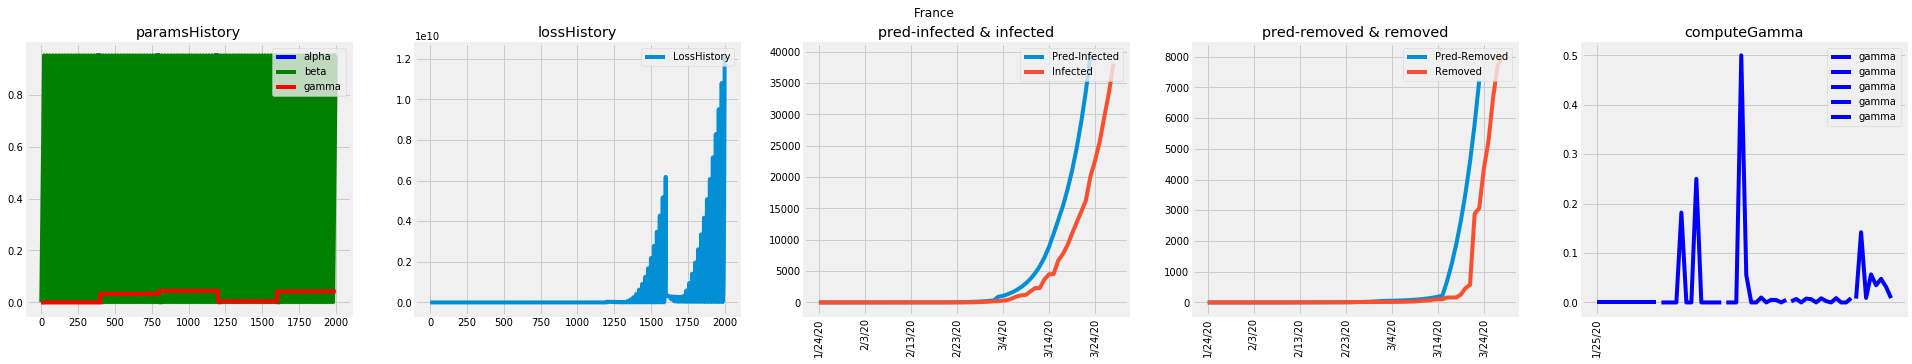

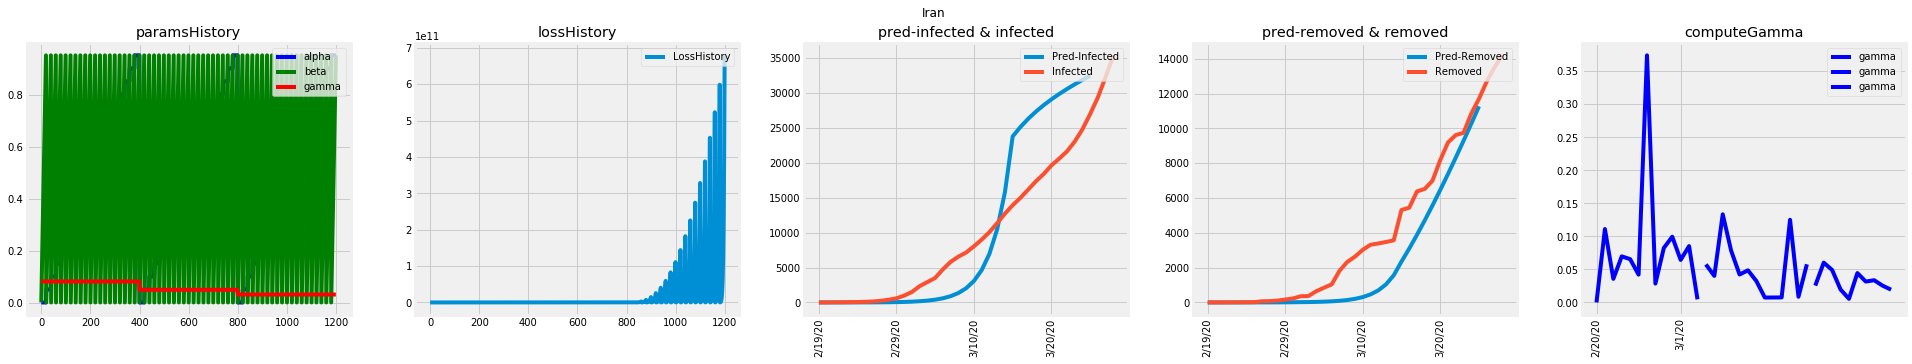

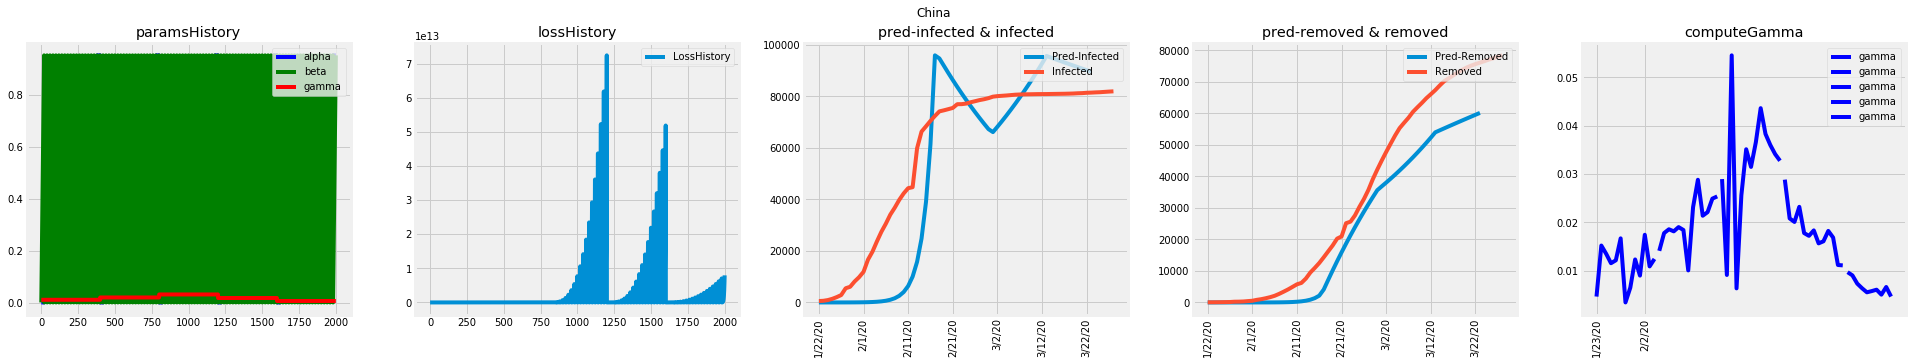

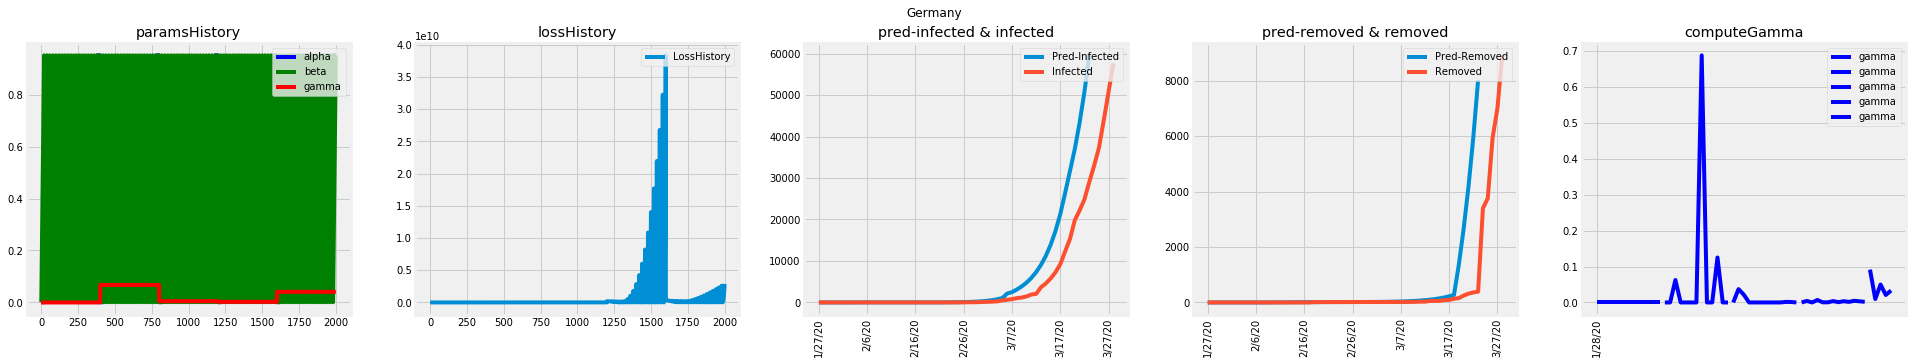

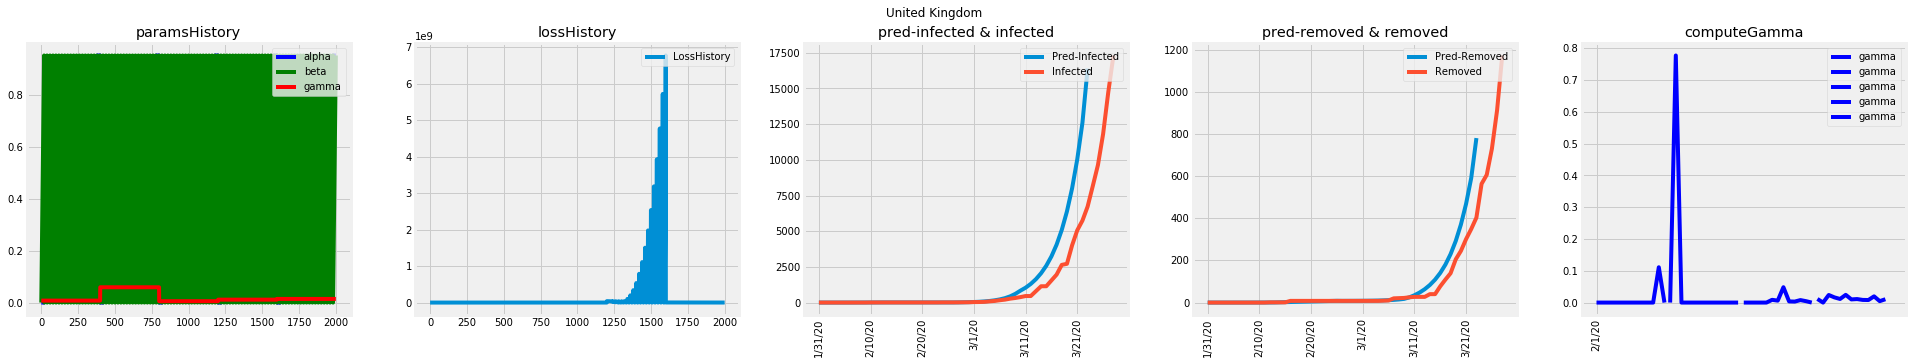

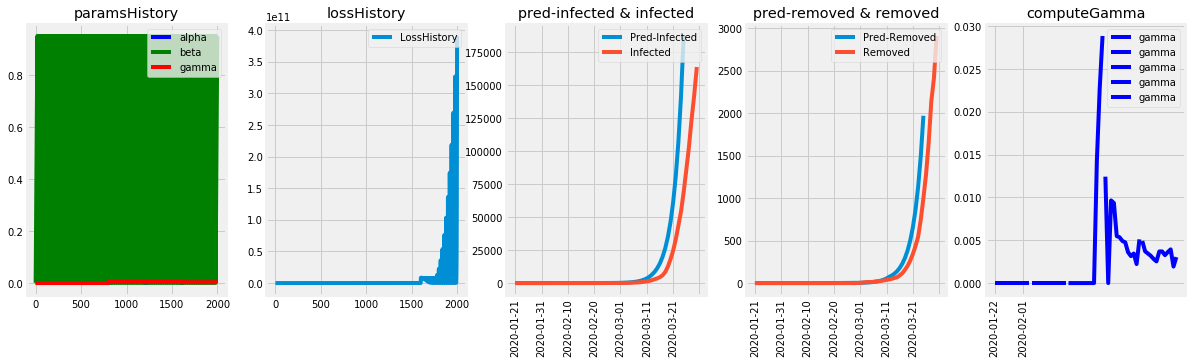

In [12]:
computeParamsWithStepSize(14)